In [ ]:
# installing dependencies
!pip install gradio transformers python-docx python-pptx googletrans==4.0.0-rc1 PyMuPDF reportlab sentence-transformers faiss-gpu fpdf

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of gradio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of gradio to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 486.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.4 MB/s 

In [10]:
import gradio as gr
import fitz  # PyMuPDF for PDF
from pptx import Presentation  # for PPTX
from docx import Document  # for DOCX
from transformers import pipeline

# Load a better model for text generation
generator = pipeline('text-generation', model='gpt2')

# Function to extract text based on file type
def extract_text_from_file(file):
    if file.name.endswith('.pdf'):
        doc = fitz.open(stream=file.read(), filetype="pdf")
        text = ''.join([page.get_text() for page in doc])
    elif file.name.endswith('.pptx'):
        prs = Presentation(file)
        text = ''.join([shape.text for slide in prs.slides for shape in slide.shapes if hasattr(shape, "text")])
    elif file.name.endswith('.docx'):
        doc = Document(file)
        text = '\n'.join([para.text for para in doc.paragraphs])
    elif file.name.endswith('.txt'):
        text = file.read().decode("utf-8")
    else:
        text = 'Unsupported file format'
    return text

# Function to generate the tender document
def generate_tender(prompt_file, tender_files, country_code):
    prompt_text = extract_text_from_file(prompt_file)
    tender_texts = [extract_text_from_file(f) for f in tender_files]
    previous_tenders = '\n'.join(tender_texts)

    # Combine prompt and previous tenders for generation
    combined_text = f"Prompt: {prompt_text}\nPrevious Tenders: {previous_tenders}\nCountry Code: {country_code}"

    # Generate the tender
    generated_tender = generator(combined_text, max_length=1024)  # Adjust max_length as needed
    return generated_tender[0]['generated_text'], prompt_text

# Gradio interface
def interface():
    with gr.Blocks() as iface:
        gr.Markdown("# Tender Document Generator")

        with gr.Row():
            prompt_file = gr.File(label="Upload Prompt File")
            tender_files = gr.File(label="Upload Previous Tender Files", file_count="multiple")
            country_code = gr.Dropdown(label="Country Code", choices=["EN", "FR", "ES", "DE", "CN"])

        generate_btn = gr.Button("Generate Tender")
        output = gr.Textbox(label="Generated Tender", lines=10)

        def generate_tender_wrapper(prompt_file, tender_files, country_code):
            if not isinstance(tender_files, list):
                tender_files = [tender_files]  # Ensure it's a list
            generated_tender, prompt_text = generate_tender(prompt_file, tender_files, country_code)
            global stored_prompt, stored_generated_tender
            stored_prompt = prompt_text
            stored_generated_tender = generated_tender
            return generated_tender

        generate_btn.click(fn=generate_tender_wrapper, inputs=[prompt_file, tender_files, country_code], outputs=output)

    iface.launch()

if __name__ == "__main__":
    interface()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


IMPORTANT: You are using gradio version 4.19.1, however version 4.29.0 is available, please upgrade.
--------
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6a3ef2740bd997cd6e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [11]:
import sqlite3

def save_to_database(prompt_text, previous_tenders, generated_tender):
    # Create a new connection to the database in the current thread
    conn = sqlite3.connect('tenders.db')
    cursor = conn.cursor()

    # Save the data to the database
    cursor.execute('''
        INSERT INTO tenders (prompt, previous_tenders, generated_tender)
        VALUES (?, ?, ?)
    ''', (prompt_text, previous_tenders, generated_tender))
    conn.commit()
    conn.close()

def generate_tender(prompt_file, tender_files, country_code):
    prompt_text = extract_text_from_file(prompt_file)
    tender_texts = [extract_text_from_file(f) for f in tender_files]
    previous_tenders = '\n'.join(tender_texts)

    # Combine prompt and previous tenders for generation
    combined_text = f"Prompt: {prompt_text}\nPrevious Tenders: {previous_tenders}\nCountry Code: {country_code}"

    # Generate the tender
    generated_tender = generator(combined_text, max_length=1024, truncation=True)  # Adjust max_length as needed

    # Save the data to the database within the same thread
    save_to_database(prompt_text, previous_tenders, generated_tender[0]['generated_text'])

    return generated_tender[0]['generated_text']

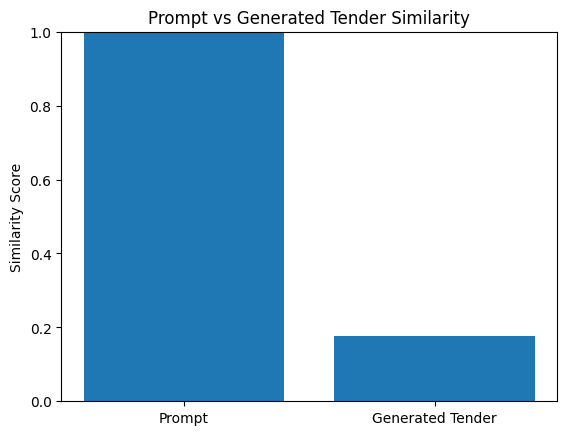

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def plot_similarity(prompt_text, generated_tender_text):
    vectorizer = TfidfVectorizer().fit_transform([prompt_text, generated_tender_text])
    vectors = vectorizer.toarray()
    similarity = cosine_similarity(vectors)[0, 1]

    # Plotting the similarity
    plt.bar(['Prompt', 'Generated Tender'], [1, similarity])
    plt.ylim(0, 1)
    plt.title('Prompt vs Generated Tender Similarity')
    plt.ylabel('Similarity Score')
    plt.show()

# Assuming you have already run the interface and generated tender
plot_similarity(stored_prompt, stored_generated_tender)